# Change Point detection in Sensor Time series data

## Install dependent libraries

In [ ]:
# rm(list=ls())

# install.packages("sqldf")
# install.packages("ggplot2")


## Load dependent libraries

In [1]:
library(sqldf)

Loading required package: gsubfn
Loading required package: proto
Warning message:
“no DISPLAY variable so Tk is not available”Loading required package: RSQLite


## Add Global Variables
Add Global Variables

In [3]:
# Sapecify file names for sample text and configuration files
sampleDataFileName = "sample_sensordata2016.csv"
sampleConfigFileName = "sample_config.txt"

## Insert credentials for reading the data from csv data store in DSX

In [4]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
getObjectStorageFileWithCredentials_273b1c76068e4fe4b6cb7633e12004f3 <- function(container, filename) {
    # This functions returns a textConnection object for a file
    # from Bluemix Object Storage.

    if(!require(httr)) install.packages('httr')
    if(!require(RCurl)) install.packages('RCurl')
    library(httr, RCurl)
    auth_url <- paste("https://identity.open.softlayer.com",'/v3/auth/tokens', sep= '')
    auth_args <- paste('{"auth": {"identity": {"password": {"user": {"domain": {"id": ', "1301cc61df814635b2dd7c9fa40e6e2a",'},"password": ',
                    "mHk4F6cpWl5R?*jZ",',"name": ', "member_03c4778cda0f6111933c34cba4d34b7a50f6eabb",'}},"methods": ["password"]}}}', sep='"')
    auth_response <- httr::POST(url = auth_url, body = auth_args)
    x_subject_token <-  headers(auth_response)[['x-subject-token']]
    auth_body <-  content(auth_response)
    access_url <-  unlist(lapply(auth_body[['token']][['catalog']], function(catalog){
        if((catalog[['type']] == 'object-store')){
            lapply(catalog[['endpoints']], function(endpoints){
                if(endpoints[['interface']] == 'public' && endpoints[['region_id']] == 'dallas') {
                    paste(endpoints[['url']], container, filename, sep='/')}
            })
        }
    }))
    data <- content(httr::GET(url = access_url, add_headers ("Content-Type" = "application/json", "X-Auth-Token" = x_subject_token)), as="text")
    textConnection(data)
}


# Function to translate from one datetime format to another datetime format
Returns character strings in the converted format NOT in posix or datetime format
DateTime passed in also should be in character string format


In [5]:
dtformatconvert <- function(indatetimes, fromdatetimeformat="%Y-%m-%d %H:%M:%S %p", todatetimeformat="%d-%m-%Y %H:%M:%S",
                            fromtz="GMT", totz="", usetz=FALSE)
{

    return(strftime(as.POSIXct(indatetimes, format=fromdatetimeformat, tz=fromtz, usetz=FALSE), 
                  format=todatetimeformat, tz=totz, usetz=FALSE))
}


# Function to read data from csv file
IN: File name, delimiter, column names (Timestamp, SensorID, Sensor value)
OUT: Data frame (Timestamp, SensorID, SensorValue)


In [6]:

f_readsensordata <- function(sensordf, sensorid, coltimestamp, colsensorid, colsensorval)
{
  # sensordf <- read.csv(paste(dirname, filename, sep=""), sep=",", as.is=TRUE, header=TRUE) ##as.is=TRUE to ensure Timestamp read in as character type
  sensordf1 <- sensordf[,c(coltimestamp, colsensorid, colsensorval)]
  names(sensordf1) <- c("TimeStamp","SensorID","SensorValue")
  if (sensorid != "ALL")
  {
    sensordf1 <- sensordf1[sensordf1$SensorID==sensorid,]
  }
  #View(alarmdf1)
  rm(sensordf)
  return(sensordf1)
}



In [ ]:
# Call function to read data for specific sensor
Copy the code snippet that resembles [getObjectStorageFileWithCredentials_273b1c76068e4fe4b6cb7633e12004f3] from your own Insert credentials step section and replace below before reading the data
Also replace the .csv file name in the call to the above function for your environment

In [7]:

# df.test <-  read.csv(file = getObjectStorageFileWithCredentials_273b1c76068e4fe4b6cb7633e12004f3("ChangePointDetection", "SensorData2016.csv"))
alarmdf <-  read.csv(file = getObjectStorageFileWithCredentials_273b1c76068e4fe4b6cb7633e12004f3("ChangePointDetection", sampleDataFileName))
head(alarmdf)


Loading required package: httr
Loading required package: RCurl
Loading required package: bitops

Attaching package: ‘RCurl’

The following object is masked from ‘package:SparkR’:

    base64



SensorID,TimeStamp,SensorValue,SensorUnits
3B1,20-03-2016 17:40:00,10.455,FAHRENHEIT
3B1,20-03-2016 17:50:00,9.840,FAHRENHEIT
3B1,20-03-2016 18:00:00,9.840,FAHRENHEIT
3B1,20-03-2016 18:10:00,24.600,FAHRENHEIT
3B1,20-03-2016 18:20:00,12.915,FAHRENHEIT
3B1,20-03-2016 18:30:00,10.455,FAHRENHEIT


You can investigate the set of unique sensor ids in the data using the below command
[unique(alarmdf$SensorID)]

### Filter data for 1 sensor for analysis, say "3B1"
### Standardise the Dataset with standard column names [Timestamp, SensorID, SensorValue]


In [9]:
v_SensorID = "3B1"

alarmdf <- f_readsensordata(sensordf = alarmdf, 
                            sensorid = "3B1", 
                            coltimestamp = "TimeStamp", colsensorid="SensorID", colsensorval="SensorValue")

head(alarmdf)

TimeStamp,SensorID,SensorValue
20-03-2016 17:40:00,3B1,10.455
20-03-2016 17:50:00,3B1,9.840
20-03-2016 18:00:00,3B1,9.840
20-03-2016 18:10:00,3B1,24.600
20-03-2016 18:20:00,3B1,12.915
20-03-2016 18:30:00,3B1,10.455


### Sort the data by Time stamp (optional if specific time series based functions not applied)

In [11]:
indatetimeformat="%Y-%m-%d %H:%M:%S"
intimezone="GMT"
alarmdf <- alarmdf[with(alarmdf, order(SensorID, as.POSIXct(TimeStamp, format=indatetimeformat, tz=intimezone))), ]
head(alarmdf)


TimeStamp,SensorID,SensorValue
20-03-2016 17:40:00,3B1,10.455
20-03-2016 17:50:00,3B1,9.840
20-03-2016 18:00:00,3B1,9.840
20-03-2016 18:10:00,3B1,24.600
20-03-2016 18:20:00,3B1,12.915
20-03-2016 18:30:00,3B1,10.455


## Function to split data into 2 datasets: Previous, Current
 IN: Standard Data Frame, SensorID, 
	Previous From Time stamp, Previous To Time stamp, 
	Current From Time Stamp, Current To Time Stamp
 OUT: Data series
		series 1 (SensorID, TimeStamp, SensorValue),
 		series 2 (SensorID, TimeStamp, SensorValue)


In [12]:
f_splitdataseries <- function(SensorID, Intimeformat, Datatimeformat, PFrom, PTo, CFrom, CTo)
{
  PFromPOSIX = as.POSIXct(PFrom, format=Intimeformat, tz="GMT", usetz=FALSE)
  PToPOSIX = as.POSIXct(PTo, format=Intimeformat, tz="GMT", usetz=FALSE)
  CFromPOSIX = as.POSIXct(CFrom, format=Intimeformat, tz="GMT", usetz=FALSE)
  CToPOSIX = as.POSIXct(CTo, format=Intimeformat, tz="GMT", usetz=FALSE)
  
  alarmdf$TimeStampPOSIX <- as.POSIXct(alarmdf$TimeStamp, format=Datatimeformat, tz="GMT", usetz=FALSE)
  
  series1 = alarmdf[which(alarmdf$SensorID ==SensorID & alarmdf$TimeStampPOSIX >= PFromPOSIX & alarmdf$TimeStampPOSIX < PToPOSIX),]
  series2 = alarmdf[which(alarmdf$SensorID ==SensorID & alarmdf$TimeStampPOSIX >= CFromPOSIX & alarmdf$TimeStampPOSIX < CToPOSIX),]
  return(list(series1, series2))
}


### Split data into 2 divergent sets for detecting changes

## Configure the parameters for extracting the 2 time series datasets



In [13]:
v_SensorID                            #is set already
v_Datatimeformat = "%d-%m-%Y %H:%M:%S"#Time format of the data in the data frame
v_Intimeformat = "%Y%m%d %H:%M:%S" #Time format which is used for specifying the time ranges in the function call
v_PFrom = "20160324 00:00:00"      #Start Time for first series
v_PTo = "20160325 00:00:00"        #End Time for first series
v_CFrom = "20160325 00:00:00"      #Start Time for second series
v_CTo ="20160326 00:00:00"         #End Time for second series


[1] "3B1"

## Get the 2 Data series to compare

In [14]:
# Get the 2 Data series to compare
# s = f_splitdataseries (SensorID="3B1",
#                       Intimeformat="%Y%m%d %H:%M:%S", Datatimeformat="%d-%m-%Y %H:%M:%S",
#                       PFrom="20160324 00:00:00", PTo="20160325 00:00:00",
#                       CFrom="20160325 00:00:00", CTo="20160326 00:00:00")

s = f_splitdataseries (SensorID=v_SensorID,
                       Intimeformat=v_Intimeformat, Datatimeformat=v_Datatimeformat,
                       PFrom=v_PFrom, PTo=v_PTo,
                       CFrom=v_CFrom, CTo=v_CTo)


# Unpack the 2 list of data frames
series1 <- s[[1]]
series2 <- s[[2]]

head(series1)
head(series2)

,TimeStamp,SensorID,SensorValue,TimeStampPOSIX
471,24-03-2016 00:00:00,3B1,9.225,2016-03-24 00:00:00
472,24-03-2016 00:10:00,3B1,8.610,2016-03-24 00:10:00
473,24-03-2016 00:20:00,3B1,8.610,2016-03-24 00:20:00
474,24-03-2016 00:30:00,3B1,8.610,2016-03-24 00:30:00
475,24-03-2016 00:40:00,3B1,8.610,2016-03-24 00:40:00
476,24-03-2016 00:50:00,3B1,8.610,2016-03-24 00:50:00


,TimeStamp,SensorID,SensorValue,TimeStampPOSIX
615,25-03-2016 00:00:00,3B1,18.450,2016-03-25 00:00:00
616,25-03-2016 00:10:00,3B1,13.530,2016-03-25 00:10:00
617,25-03-2016 00:20:00,3B1,12.300,2016-03-25 00:20:00
618,25-03-2016 00:30:00,3B1,11.685,2016-03-25 00:30:00
619,25-03-2016 00:40:00,3B1,11.685,2016-03-25 00:40:00
620,25-03-2016 00:50:00,3B1,16.605,2016-03-25 00:50:00


### Function to plot the line graphs for both the series
IN parameters: (x,y values for both the Time series in sorted order) x1, y1, x2, y2


In [15]:
f_plot2lines <- function(x1, y1, x2, y2)
{
  # Draw Line plot
  # dev.new()
  plot(y1,type="l",col="green",xlab=" ", ylab=" ",pch=21,xaxt="n",yaxt="n")
  par(new=T)
  plot(y2,type="l",col="red",xlab="Time", ylab="Values",pch=21,xaxt="n",yaxt="n")
  axis(2,las=3,cex.axis=0.8)
  axis(1,at=c(1:length(x1)),c(x1),las=2,cex.axis=0.4)
  title("Time - Value line plot")
  par(new=F)
}


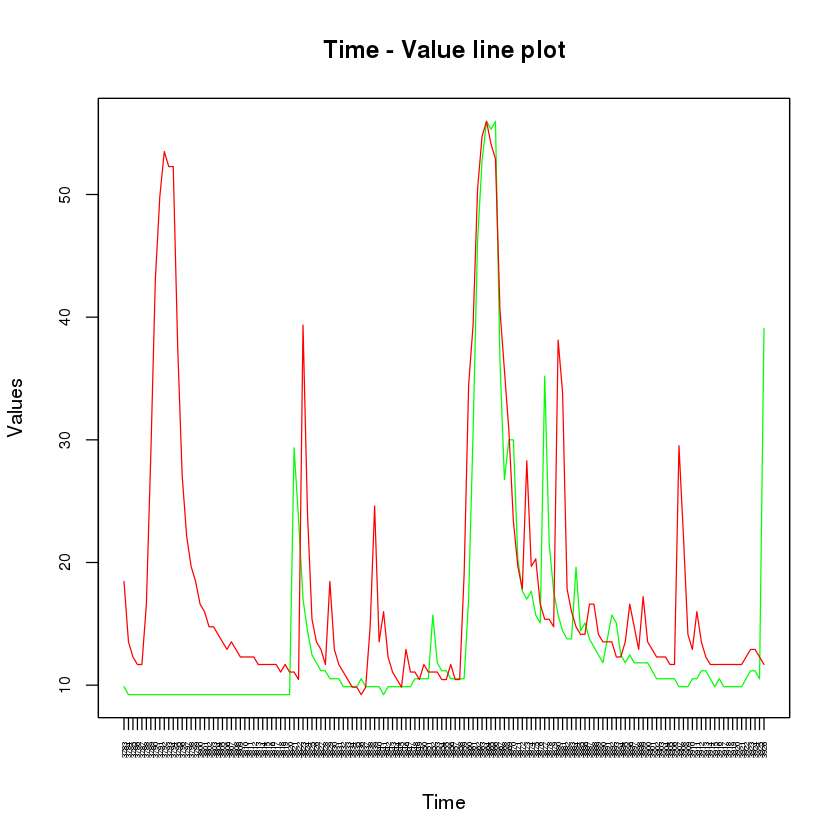

In [16]:
# Line plot of the 2 Data series
f_plot2lines(x1 <- series1$TimeStamp, y1 <- series1$SensorValue,
             x2 <- series2$TimeStamp, y2 <- series2$SensorValue)


### Function to plot the box plots for both the distributions
Time series order does not matter for this
    IN parameters: (Sensorvalues-series 1, Sensorvalues-series 2)

In [17]:
f_plot2boxes <- function(s1sensorvalue, s2sensorvalue)
{
  data_list = NULL
  col_list = c("green", "blue")
  names_list = c("Previous", "Current")
  
  data_list = list()
  data_list[[1]] = s1sensorvalue
  data_list[[2]] = s2sensorvalue
  
  # dev.new() # Works in PC only
  boxstats <- boxplot.stats(data_list[[1]], coef=1.57, do.conf = TRUE, do.out = TRUE)
  #par(new=T)
  boxplot(data_list, las = 2, col = col_list, ylim=c(-2.0,70),
          names= names_list,
          mar = c(12, 5, 4, 2) + 0.1,
          main="Cange point detection",
          sub=paste("Subject", ":", sep=""),
          ylab="Values", 
          coef=1.57, do.conf = TRUE, do.out = TRUE)
  abline(h=boxstats$stats, col="green", las=2)
}


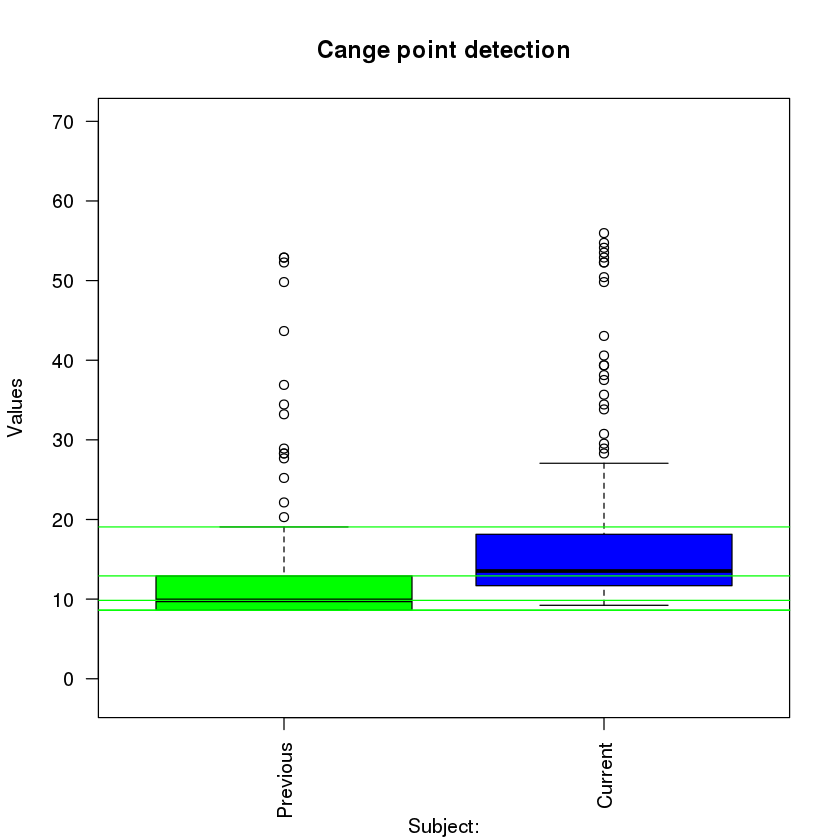

In [18]:
# Plot the 2 box plots for the distribution
f_plot2boxes(s1sensorvalue = series1$SensorValue,
             s2sensorvalue = series2$SensorValue)


## Function to calculate the stats for both the series
Avg, Median, p1sd, p2sd, p3sd, n1sd, n2sd, n3sd, q0, q1, q2, q3, q4, f1range, iqrange, f2range, sku, kurt, outliers


In [19]:
f_seriesstats <- function(series)
{
  boxstats <- boxplot.stats(series, coef=1.57, do.conf = TRUE, do.out = TRUE)
  smin <- min(series)
  smax <- max(series)
  smean <- mean(series)
  #Spread measures
  sq0 <- boxstats$stats[1]
  sq1 <- boxstats$stats[2]
  sq2 <- boxstats$stats[3]
  sq3 <- boxstats$stats[4]
  sq4 <- boxstats$stats[5]
  siqr <- (sq3 - sq1)
  # Normal distribution
  s1sd <- sd(series)
  s1sdp <- smean + s1sd
  s1sdn <- smean - s1sd
  s2sdp <- smean + (2*s1sd)
  s2sdn <- smean - (2*s1sd)
  s3sdp <- smean + (3*s1sd)
  s3sdn <- smean - (3*s1sd)
  # Outlier counts @ 2sd
  s2sdout <- sum(series > s2sdp) + sum(series < s2sdn)
  # return(list(smin, smax, smean, sq0, sq1, sq2, sq3, sq4, siqr, s1sd, s1sdp, s1sdn, s2sdp, s2sdn, s3sdp, s3sdn))
  return(list(smin=smin, smax=smax, smean=smean,
              sq0=sq0, sq1=sq1, sq2=sq2, sq3=sq3, sq4=sq4, siqr=siqr,
              s1sd=s1sd, s1sdp=s1sdp, s1sdn=s1sdn,
              s2sdp=s2sdp, s2sdn=s2sdn, s3sdp=s3sdp, s3sdn=s3sdn))
}


## Compute the statistics for both series and check results

In [20]:
# Compute the statistics for both series and check results
s1stats <- f_seriesstats(series1$SensorValue)
str(s1stats)

s2stats <- f_seriesstats(series2$SensorValue)
str(s2stats)


List of 16
 $ smin : num 8.61
 $ smax : num 52.9
 $ smean: num 13.1
 $ sq0  : num 8.61
 $ sq1  : num 8.61
 $ sq2  : num 9.84
 $ sq3  : num 12.9
 $ sq4  : num 19.1
 $ siqr : num 4.3
 $ s1sd : num 8.86
 $ s1sdp: num 21.9
 $ s1sdn: num 4.21
 $ s2sdp: num 30.8
 $ s2sdn: num -4.65
 $ s3sdp: num 39.7
 $ s3sdn: num -13.5
List of 16
 $ smin : num 9.22
 $ smax : num 56
 $ smean: num 18.2
 $ sq0  : num 9.22
 $ sq1  : num 11.7
 $ sq2  : num 13.5
 $ sq3  : num 18.1
 $ sq4  : num 27.1
 $ siqr : num 6.46
 $ s1sd : num 11.4
 $ s1sdp: num 29.6
 $ s1sdn: num 6.72
 $ s2sdp: num 41.1
 $ s2sdn: num -4.72
 $ s3sdp: num 52.5
 $ s3sdn: num -16.2


## Functions to calculate change point deviatrions

In [22]:
## Function to calculate change point deviatrion percentages
f_changepercent <- function(val1, val2)
{
  return(((val2-val1)/val1)*100)
}

# Calculate percentage deviation for individual stats
f_serieschangepercent <- function(series1stats, series2stats)
{
  n <- length(series1stats)
  cols=names(series2stats)
  cpdf <- data.frame(statname=character(), series1val = numeric(), series2val=numeric(), changeper=numeric())
  for (i in 1:length(series2stats))
  {
    newrow = data.frame(statname=cols[i], 
                        series1val=series1stats[[i]], 
                        series2val=series2stats[[i]], 
                        changeper=f_changepercent(series1stats[[i]], series2stats[[i]]))
    cpdf <- rbind(cpdf, newrow)
  }
  return(cpdf)
}

# Calculate overall percentage deviation and detect change point
f_detectchangepoint <- function(dfcp, threshold)
{
  # Overall percentage deviation
  newrow = data.frame(statname='overall', 
                      series1val=NA, 
                      series2val=NA, 
                      changeper=mean(abs(dfcp$changeper)))
  dfcp <- rbind(dfcp, newrow)
  # Overall change point percentage
  changepointper <- dfcp[which(dfcp$statname=="overall"),c("changeper")]
  # Mark change point at threshold %
  if(changepointper > threshold)
        {return(paste("Change Point DETECTED exceeding threshold: ",threshold,"% ", sep=""))}
    else
        {return(paste("Change Point NOT DETECTED at threshold: ",threshold,"% ", sep=""))}
}


## Overall change percentage in key stats


In [23]:
# Set the threshold percentage of change if detected
v_ThresholdPercent = 25

In [24]:
# Overall change percentage in key stats
dfallstats <- f_serieschangepercent(s1stats, s2stats)
print(dfallstats)
# View(dfallstats)
# Detect changepoint
f_detectchangepoint(dfallstats, v_ThresholdPercent)


   statname series1val series2val changeper
1      smin   8.610000   9.225000  7.142857
2      smax  52.890000  55.965000  5.813953
3     smean  13.073021  18.168125 38.974191
4       sq0   8.610000   9.225000  7.142857
5       sq1   8.610000  11.685000 35.714286
6       sq2   9.840000  13.530000 37.500000
7       sq3  12.915000  18.142500 40.476190
8       sq4  19.065000  27.060000 41.935484
9      siqr   4.305000   6.457500 50.000000
10     s1sd   8.861824  11.444024 29.138478
11    s1sdp  21.934845  29.612149 35.000497
12    s1sdn   4.211197   6.724101 59.671956
13    s2sdp  30.796669  41.056174 33.313685
14    s2sdn  -4.650627  -4.719924  1.490057
15    s3sdp  39.658493  52.500198 32.380721
16    s3sdn -13.512451 -16.163948 19.622625


[1] "Change Point DETECTED exceeding threshold: 25% "